In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tqdm import tqdm

In [2]:
DATA_DIR = '/Users/andishetavakkoli/Documents/notebook/github_project/machine-learning-projects-data/anomaly_detection'

In [3]:
df = pd.read_csv(DATA_DIR + '/creditcard.csv')

In [4]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [11]:
df.shape

(284807, 31)

In [20]:
y_sample.unique()

array([0])

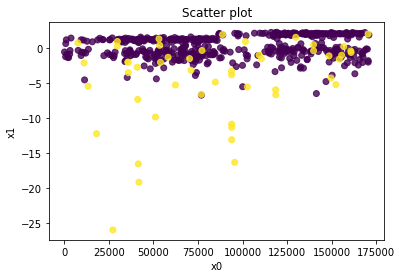

In [28]:
# Plot
inlier_df = df[df['Class'] == 0].sample(500)
outlier_df = df[df['Class'] == 1].sample(50)
concat_df = pd.concat([inlier_df, outlier_df], axis=0)

X_plot = concat_df.drop(['Class'], axis=1)
y_plot = concat_df[['Class']]

plt.scatter(
    X_plot.iloc[:, 0],
    X_plot.iloc[:, 1],
    c=y_plot.iloc[:, 0],
    alpha=0.8)
plt.title('Scatter plot')
plt.xlabel('x0')
plt.ylabel('x1')
plt.show()

In [70]:
from pyod.models.lof import LOF
from pyod.utils.utility import standardizer
from pyod.models.combination import aom, moa, average, maximization

In [71]:
# Create X, y
X = concat_df.drop(['Class'], axis=1)
y = concat_df[['Class']]

# Split X, y train , test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Standardize data
X_train_norm, X_test_norm = standardizer(X_train, X_test)

In [72]:
n_lof = 20
k_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 
 120, 130, 140, 150, 160, 170, 180, 190, 200]

train_scores.shape
test_scores.shape

(165, 20)

In [73]:
train_scores = np.zeros([X_train.shape[0], n_lof])
test_scores = np.zeros([X_test.shape[0], n_lof])

# Modeling
for i in range(n_lof):
    k = k_list[i]
    lof = LOF(n_neighbors=k) 
    lof.fit(X_train_norm)

    # Store the results in each column:
    train_scores[:, i] = lof.decision_scores_
    test_scores[:, i] = lof.decision_function(X_test_norm) 
# Decision scores have to be normalized before combination
train_scores_norm, test_scores_norm = standardizer(train_scores,test_scores)

In [74]:
lof.threshold_

1.4951295249619303

In [75]:
X_train_norm.shape

(385, 30)

In [76]:
X_test_norm.shape

(165, 30)

In [77]:
train_scores.shape

(385, 20)

In [86]:
train_scores[train_scores < 90].min()

0.9537018748216337

In [79]:
train_scores.shape

(385, 20)

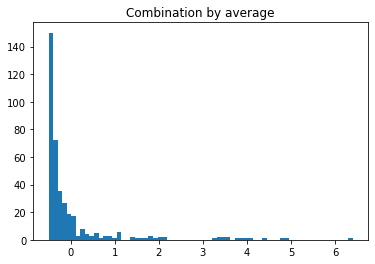

In [87]:
# Combination by average
# The test_scores_norm is 500 x 20. The "average" function will take the average of the 20 columns. The result "y_by_average" is a single column: 
y_by_average = average(train_scores_norm)
import matplotlib.pyplot as plt
plt.hist(y_by_average, bins='auto') # arguments are passed to np.histogram
plt.title("Combination by average")
plt.show()

In [89]:
def descriptive_stat_threshold(df,pred_score, threshold):
    # Let's see how many '0's and '1's.
    df = pd.DataFrame(df)
    df['Anomaly_Score'] = pred_score
    df['Group'] = np.where(df['Anomaly_Score']< threshold, 'Normal', 'Outlier')

    # Now let's show the summary statistics:
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score':'Count'})
    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100 # The count and count %
    stat = df.groupby('Group').mean().round(2).reset_index() # The avg.
    stat = cnt.merge(stat, left_on='Group',right_on='Group') # Put the count and the avg. together
    return (stat)

In [92]:
descriptive_stat_threshold(X_train,y_by_average, 2)

,Group,Count,Count %,Time,V1,V2,V3,V4,V5,V6,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Anomaly_Score
0,Normal,367,95.324675,93018.72,0.05,0.12,-0.15,0.19,0.04,0.00,...,0.05,-0.03,-0.01,-0.04,-0.01,0.02,0.02,0.03,85.29,-0.18
1,Outlier,18,4.675325,64138.28,-8.88,5.81,-11.15,5.92,-6.21,-2.22,...,2.45,-0.64,-1.35,0.15,-0.02,-0.04,0.47,0.13,270.65,3.70
